In [1]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1
Tue Nov  7 10:00:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 31%   37C    P8     6W / 250W |   2193MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ... 

In [3]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [4]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

In [5]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[13:40:55.017] INFO   CaloQVAE                                          Willkommen!
[13:40:55.020] INFO   CaloQVAE                                          Loading configuration.


In [6]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/fast_scratch/QVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/fast_scratch/QVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

2023-11-03 13:40:58,071 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[13:40:58.071] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [7]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [8]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[13:41:04.206] INFO   data.dataManager                                  Loading Data
[13:41:14.327] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f14f1f1ba00>: 80000 events, 625 batches
[13:41:14.331] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f1592423250>: 10000 events, 10 batches
[13:41:14.332] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f13c4509520>: 10000 events, 10 batches
[13:41:19.595] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasCRBMCNNDCond
2023-11-03 13:41:19,602 dwa

40105 28512
Initializing NetworkV3


{'__name__': 'engine', '__doc__': None, '__package__': 'engine', '__loader__': <_frozen_importlib_external._NamespaceLoader object at 0x7f158a810340>, '__spec__': ModuleSpec(name='engine', loader=<_frozen_importlib_external._NamespaceLoader object at 0x7f158a810340>, submodule_search_locations=_NamespacePath(['/home/sgonzalez/CaloQVAE/engine', '/home/sgonzalez/CaloQVAE/engine', '/home/sgonzalez/CaloQVAE/engine', '/home/sgonzalez/CaloQVAE/engine', '/home/sgonzalez/CaloQVAE/engine'])), '__file__': None, '__path__': _NamespacePath(['/home/sgonzalez/CaloQVAE/engine', '/home/sgonzalez/CaloQVAE/engine', '/home/sgonzalez/CaloQVAE/engine', '/home/sgonzalez/CaloQVAE/engine', '/home/sgonzalez/CaloQVAE/engine']), 'engineBase': <module 'engine.engineBase' from '/home/sgonzalez/CaloQVAE/engine/engineBase.py'>, 'engine': <module 'engine.engine' from '/home/sgonzalez/CaloQVAE/engine/engine.py'>}


In [24]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[14:03:04.498] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[14:03:04.500] INFO   wandb                                             Watching
/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[14:03:07.192] INFO   engine.engineAtlas                                Setting up engine Atlas.
[14:03:07.195] INFO   engine.engineCaloV3                               Setting up engine Calo.
[14:03:07.196] INFO   engine.engine                                     Setting up default engine.


In [25]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[14:03:22.850] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f1438302a30>: 80000 events, 625 batches
[14:03:22.852] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f142eff3190>: 10000 events, 10 batches
[14:03:22.854] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f142eff3610>: 10000 events, 10 batches


In [26]:
###LOAD MODEL

In [27]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [28]:

# generous-wave-3
run_path = "/home/sgonzalez/CaloQVAE/outputs/2023-10-30/10-30-17/wandb/run-20231030_103022-00s3l2jo/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
modelname = 'rich-totem-1356'
datascaled = 'scaled'
with open("/home/sgonzalez/CaloQVAE/outputs/2023-10-30/10-30-17/wandb/run-20231030_103022-00s3l2jo/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

GumBoltAtlasCRBMCNNDCond
electron-ds2
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
Loading weights for module =  sampler


In [29]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2'}

In [30]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([1024, 6480])


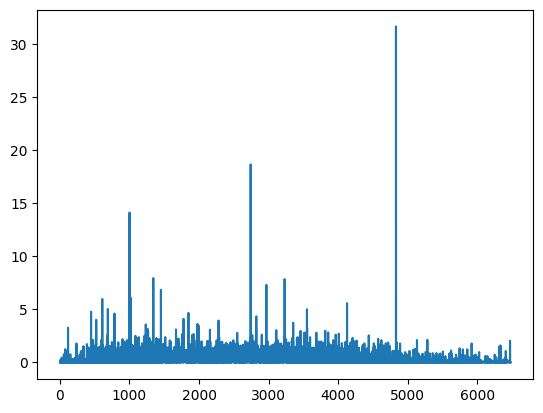

In [31]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

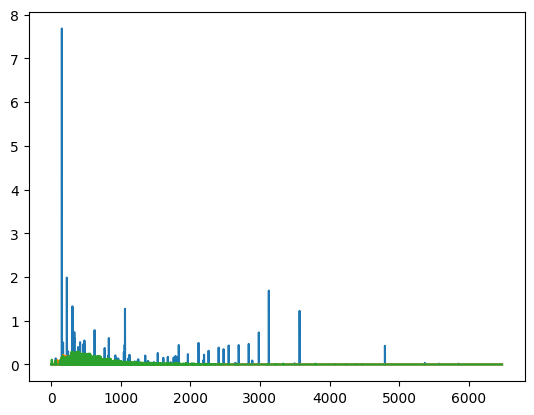

In [32]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    # if reducedata:
    #     in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 10
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:])
plt.plot(sample_data.detach().cpu().numpy()[idx,:])

In [33]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
# plt.plot(post_samples[0][0,:].detach().cpu().numpy())
# post_samples = torch.cat(post_samples, 1)

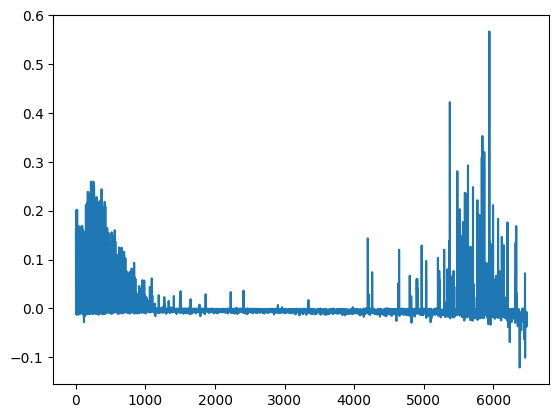

In [34]:
# post_samples = torch.cat([post_samples, true_energy], dim=1)
post_samples = torch.cat(post_samples,1)
# output_hits, output_activations = engine.model.decoder(post_samples)
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


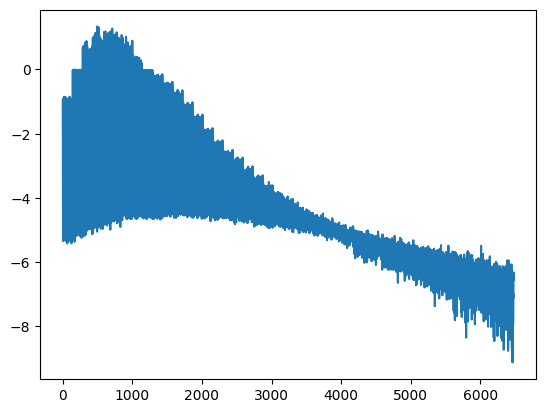

In [35]:
# self._hit_smoothing_dist_mod(output_hits, beta, is_training)
plt.plot(output_hits[1,:].detach().cpu().numpy())
beta = torch.tensor(5, dtype=torch.float, device=output_hits.device, requires_grad=False)

In [36]:
beta = torch.tensor(1, dtype=torch.float, device=output_hits.device, requires_grad=False)

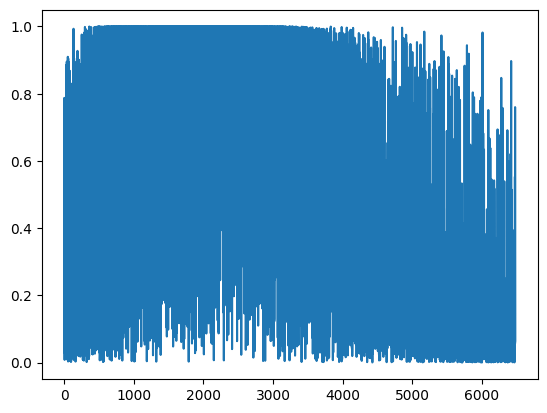

In [37]:
plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, beta, True)[2,:].detach().cpu().numpy())

In [38]:
# for i in range(1,100):
#     print(533 % i, i, 533/i)

In [39]:
# fwd_output.output_activations.shape

In [40]:
(output_hits.sum(dim=0) == 0).sum()
engine._config.model.output_smoothing_fct

# engine.model._energy_activation_fct
beta = torch.tensor(engine._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)
output = engine.model._energy_activation_fct(output_activations) * engine.model._hit_smoothing_dist_mod(output_hits, beta, False)
o1 = engine.model._energy_activation_fct(output_activations)
o2 = engine.model._hit_smoothing_dist_mod(output_hits, beta, False)

In [41]:
(output.sum(dim=0) == 0).sum()
(o1.sum(dim=0) == 0).sum()
# (o2.sum(dim=0) == 0).sum()
# (in_data.sum(dim=0) == 0).sum()
# in_data.shape
# engine.model._energy_activation_fct

tensor(0, device='cuda:0')

In [42]:
# true_energy
# rbm_vis.device
# engine._model.decoder

In [43]:
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
scaled = True
# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
for xx in val_loader:
# for xx in train_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    if reducedata:
        in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), False)
    if reducedata:
        in_data = engine._reduceinv(in_data, true_energy, R=R)
        recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
        engine._model.sampler._batch_size = true_energy.shape[0]
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
    elif scaled:
        in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
        recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
        engine._model.sampler._batch_size = true_energy.shape[0]
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
        engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
        # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
        sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))

    # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
#     if engine._config.engine.cl_lambda:
#         labelsrecon_samples.append(fwd_output.labels.detach().cpu())
#         labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )
    
#         en_labels.append(true_energy.detach().cpu())
    
    xtarget_samples.append(in_data.detach().cpu())
    xrecon_samples.append( recon_data.detach().cpu())
    xgen_samples.append( sample_data.detach().cpu())
    entarget_samples.append(true_energy.detach().cpu())
    
    # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# if engine._config.engine.cl_lambda:
#     labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
#     labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
#     en_labels = torch.cat(en_labels, dim=0)

#     lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
#     l = torch.argmax(labelstarget_samples, dim=1).numpy()


In [44]:
(xgen_samples.sum(dim=0) == 0).sum()
(xrecon_samples.sum(dim=0) == 0).sum()
# (xtarget_samples.sum(dim=0) == 0).sum()
# print((xgen_samples.sum(dim=0) == 0).nonzero(as_tuple=True))
# print((xrecon_samples.sum(dim=0) == 0).nonzero(as_tuple=True))

tensor(4)

gen
0


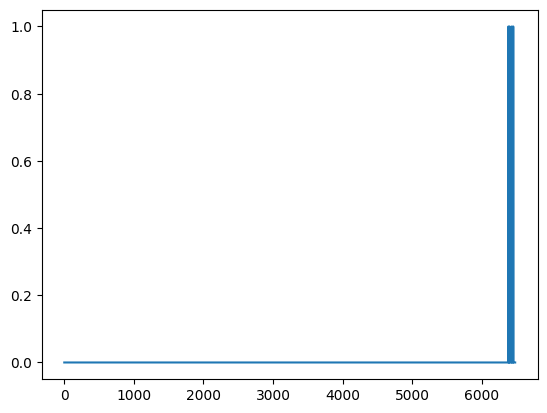

In [45]:

# # (xrecon_samples.sum(dim=1) == 0)[0].item()
# for i, iszero in enumerate(xrecon_samples.sum(dim=0) == 0):
#     if iszero:
#         print(i)
# print("gen")        
# for i, iszero in enumerate(xgen_samples.sum(dim=0) == 0):
#     if iszero:
#         print(i)

l1 = 0
for i, iszero in enumerate(xtarget_samples.sum(dim=0) == 0):
    if iszero:
        # print(i)
        l1 +=1

l2 = []
for i, iszero in enumerate(xrecon_samples.sum(dim=0) == 0):
    if iszero:
        # print(i)
        # l2 +=1
        l2.append(1)
    else:
        l2.append(0)
print("gen") 
l3 = []
for i, iszero in enumerate(xgen_samples.sum(dim=0) == 0):
    if iszero:
        # l3+=1
        l3.append(1)
    else:
        l3.append(0)
    
print(l1)
plt.plot(l2)
# plt.plot(l3)
plt.show()

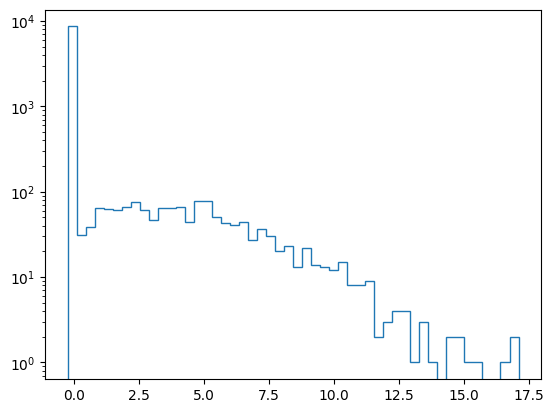

In [46]:
idx = 1
plt.hist(xrecon_samples[:,idx], bins=50, log=True, histtype='step')
plt.show()

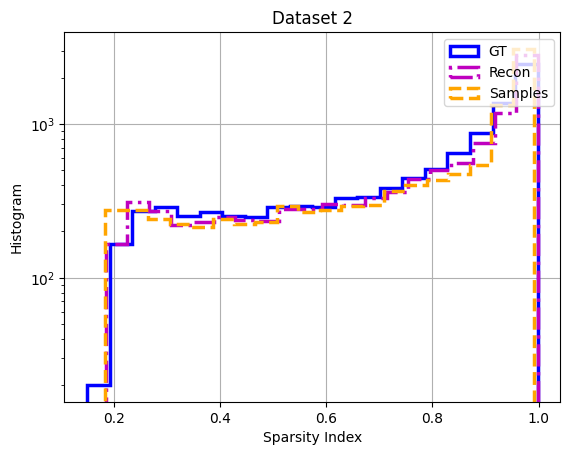

In [47]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples"])
plt.title(f'{ds[part]}')
plt.grid("True")
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [48]:
# idxPrev = 0
# # for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(1,5)]):
# # for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.xlabel("Sparsity Index")
#     plt.ylabel("Histogram")
#     plt.legend(["GT", "Recon", "Sample"])
#     plt.title(f'{part} Layer {i}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

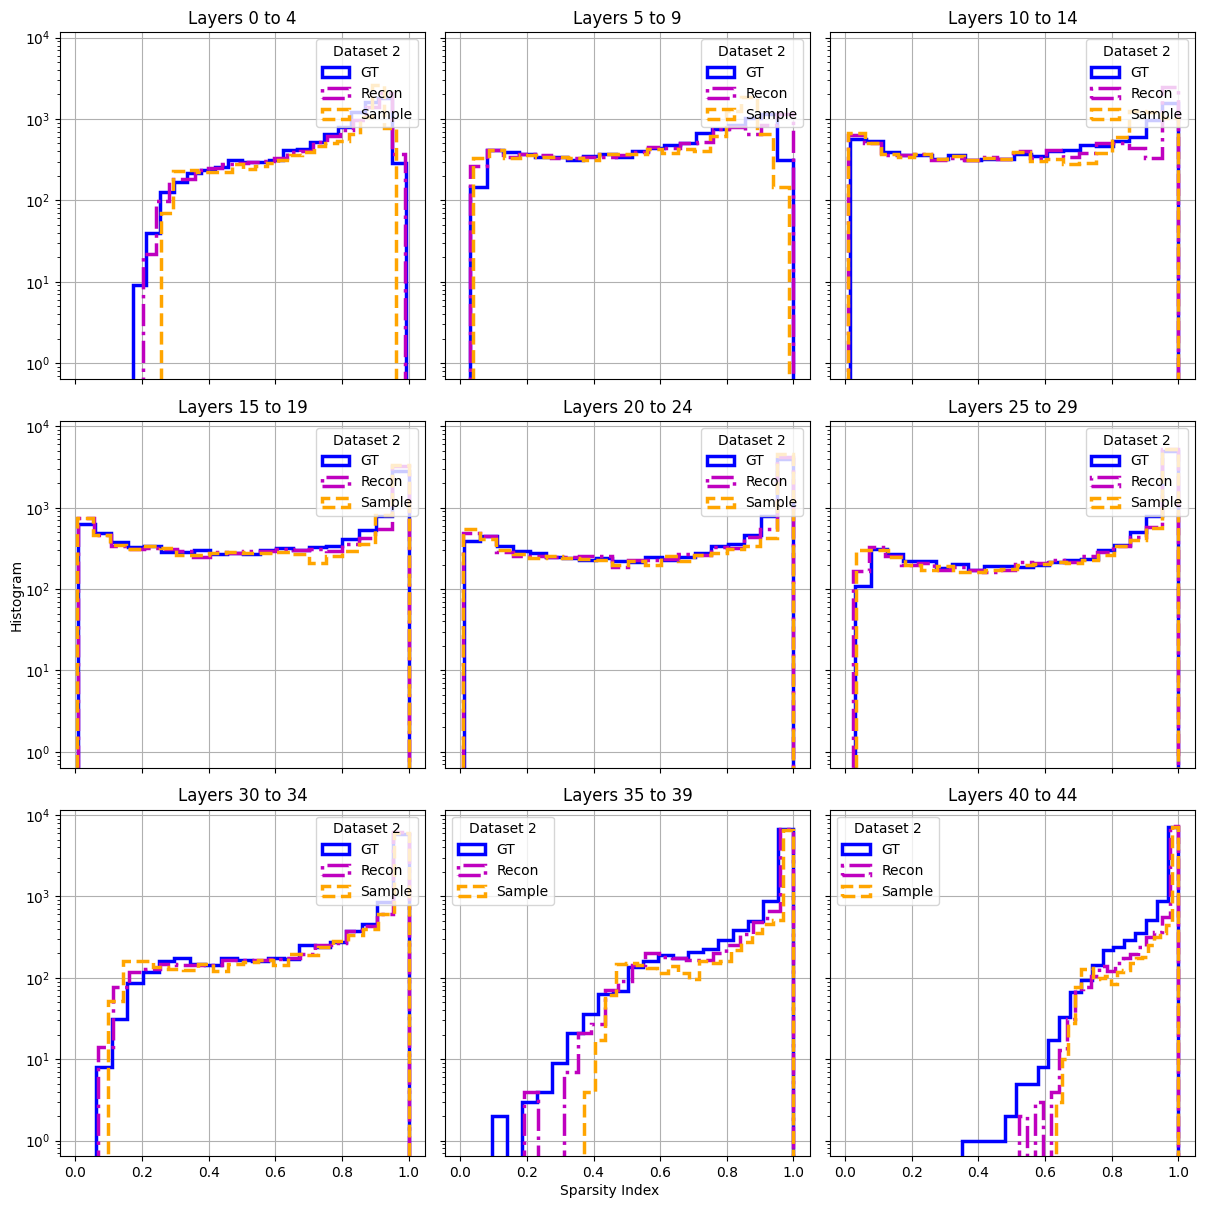

In [49]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, 0.0, 'Sparsity Index', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


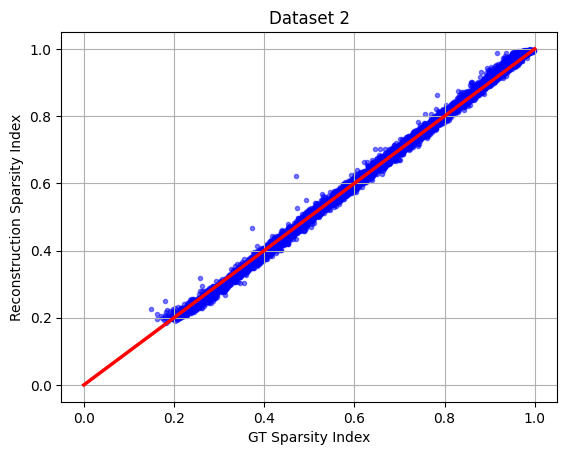

In [50]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="b")
plt.plot([0,1],[0,1], c='red', lw=2.5)
plt.xlabel('GT Sparsity Index')
plt.ylabel('Reconstruction Sparsity Index')
plt.title(f'{ds[part]}')
plt.grid("True")
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [51]:
# idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# # for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.scatter(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), marker='.', alpha=.2)
#     plt.plot([0,1],[0,1], c='red', lw=2)
#     plt.xlabel('sparsity index input')
#     plt.ylabel('sparsity index recon')
#     plt.title(f'{part}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

In [52]:
tmp = (entarget_samples < 15000) * (entarget_samples > 10000)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
len(idxEnFilter)

591

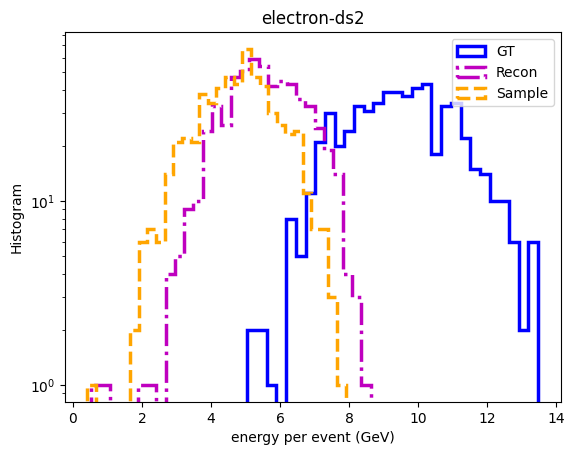

In [53]:
plt.hist(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")

plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample"])
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

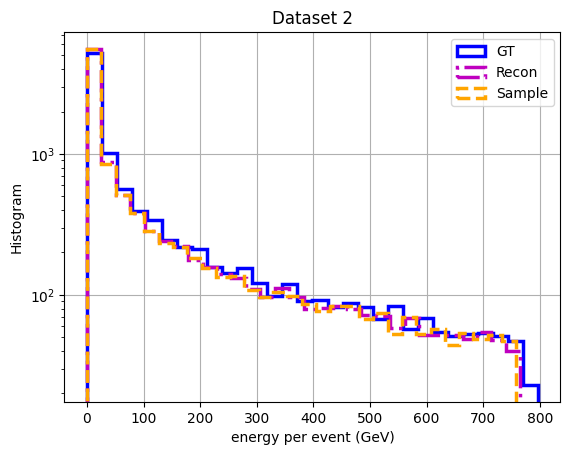

In [54]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step')
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample"])
plt.title(f'{ds[part]}')
plt.grid("True")
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

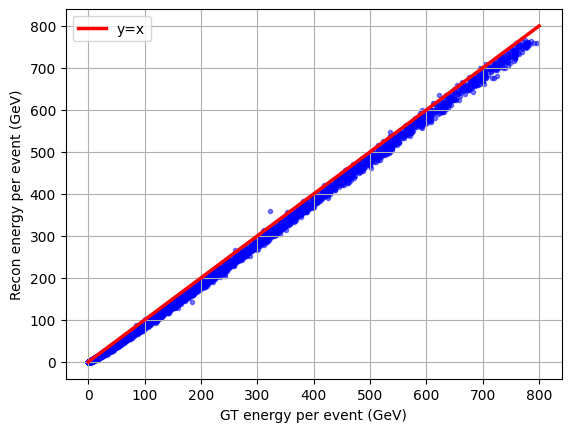

In [55]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
plt.plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
plt.legend()
plt.grid("True")
plt.xlabel("GT energy per event (GeV)")
plt.ylabel("Recon energy per event (GeV)")
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

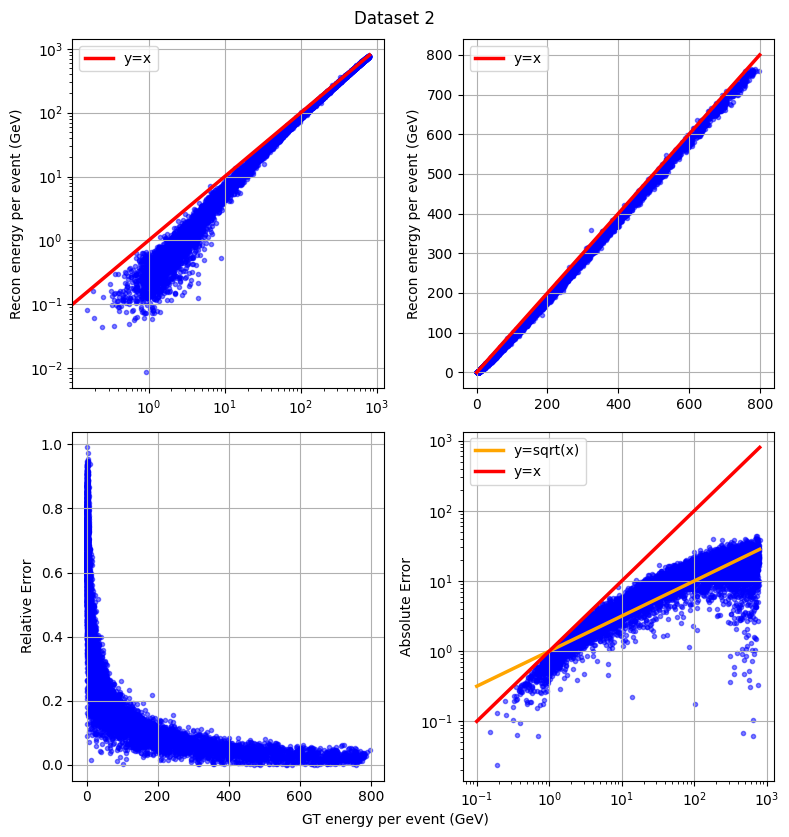

In [56]:
fig, axes = plt.subplots(2,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
axes[0,0].set_ylabel("Recon energy per event (GeV)")
axes[0,0].legend()
axes[0,0].grid("True")
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')

axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,1].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
axes[0,1].set_ylabel("Recon energy per event (GeV)")
axes[0,1].legend()
axes[0,1].grid("True")

axes[1,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/xtarget_samples.sum(dim=1).numpy(), marker='.', alpha=.5, color="blue")
# axes[1,0].set_title(f'{ds[part]}')
axes[1,0].grid("True")
# axes[1,0].set_xlabel("GT energy per event (GeV)")
axes[1,0].set_ylabel("Relative Error")

axes[1,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.5, color="blue")
axes[1,1].plot([0.1,800],np.sqrt([0.1,800]), c='orange', lw=2.5, label='y=sqrt(x)')
axes[1,1].plot([0.1,800],[0.1,800], c='red', lw=2.5, label='y=x')
# axes[1,1].set_title(f'{ds[part]}')
axes[1,1].grid("True")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_ylabel("Absolute Error")
axes[1,1].legend()
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_4panels_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [ ]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
#plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


In [ ]:
# idxPrev = 0
# # for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(1,20)]):
# # for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     # plt.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
#     # plt.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
#     # plt.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1), log=True, histtype='step')
#     plt.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step')
#     plt.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step')
#     plt.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step')
#     plt.xlabel("energy per event (GeV)")
#     plt.ylabel("Histogram")
#     plt.legend(["GT", "Recon", "Sample"])
#     plt.title(f'{part}')
#     # # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

In [ ]:
# idxPrev = 0
# # for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(10,20)]):
# # for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.scatter(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, marker='.', alpha=.2)
#     plt.plot([0,xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000],[0,xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000], c='red', lw=2)
    
#     plt.xlabel("input energy per event (GeV)")
#     plt.ylabel("recon energy per event (GeV)")
#     plt.title(f'{part}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

In [ ]:
np.unique(HLF_1_pions.bin_edges)

In [ ]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [ ]:
if reducedata:
    in_data = engine._reduce(in_data, true_energy, R=R)
fwd_output = engine.model((in_data, true_energy), False)
if reducedata:
    in_data = engine._reduceinv(in_data, true_energy, R=R)
    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
elif scaled:
    print('scaled')
    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
    engine._model.sampler._batch_size = true_energy.shape[0]
    # try:
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    # except:
        # pass
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))

In [ ]:
#(recon_data<0).sum()
#(recon_data>0).sum()
plt.plot((recon_data<0).sum(axis=0))

In [ ]:
plt.plot(torch.min(recon_data, dim=0).values)
plt.show()
plt.plot(torch.max(recon_data, dim=0).values)

In [ ]:
(fwd_output.output_activations<0).sum()

In [ ]:
HLF_1_pions.relevantLayers = [1,2,3,4,5,6,7]

In [ ]:
HLF_1_electron.relevantLayers = [5,10,15,30,35]

In [ ]:
# (((in_data[:,0:108] - recon_data[:,0:108])/(in_data[:,0:108]))**2).sum(dim=1).argsort()[:20]
(((in_data - recon_data)/(in_data+1e-5))**2).sum(dim=1).argsort()[-10:-1]
# (((in_data - recon_data))**2).sum(dim=1).argsort()[:20]

In [ ]:
idx=789
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)

# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), 
                             # filename=f'/home/javier/Projects/CaloQVAE/figs/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
#HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)


In [ ]:
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), 
#                              filename=f'/home/javier/Projects/CaloQVAE/figs/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
#HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)


In [ ]:
# HLF_1_pions.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawAverageShower(in_data[idx:idx+10,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), 
#                              filename=f'/home/javier/Projects/CaloQVAE/figs/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
#HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)